# Support Vector Machine Predictive Model for EDTA QC Evaluation: Part 1 – Model Building

We will build a **Support Vector Machine** (SVM) classifier using **scikit-learn**. Two datasets (training and testing) containing experimental data from healthy donors (described in the current manuscript: https://neco.cz..........................) are used for model development.


Contents:
- **Data Preprocessing Before Loading**

- **Module Imports**

- **Importing and Preprocessing Training and Validation data**
    - Importing data
    - Splitting the data into independent and dependent variables
    - Splitting into training and validation sets (80/20)
    - Scaling  
    - PCA scree plot
    - PCA plots with 2 principal components

- ** SVM with RBF kernel**
    - RBF kernel: PCA transformation and ROC curves 
    - RBF kernel: validation curves (check for overfitting) 
    - RBF kernel: selecting optimal hyperparameters with cross-validation (Pipeline + GridSearchCV)
    - RBF kernel: visualization of the decision boundary

- ** SVM with Polynomial kernel**    
    - Polynomial kernel: validation curves (check for overfitting) 
    - Polynomial kernel: selecting optimal hyperparameters with cross-validation (Pipeline + GridSearchCV)
    - Polynomial kernel: visualizing the decision boundary using the two PCs  

 - **Building the Final SVM pipeline**
    - Prediction results using both models
    - Selection of the final SVM model
    - Forming pipeline from scaler, PCA, and best polynomial SVM 

----
----

#### **Data Preprocessing Before Loading**

The first step is to clean the data.
- Any samples with missing data were excluded. 
- Data were normalized using three reference genes: GAPDH, GUSB, and PPIB (sequences of optimized primers can be found at https://pubmed.ncbi.nlm.nih.gov/25369468/).
- Data were checked for outliers, which were excluded (no outliers are allowed in the training data). 
- In Genex Enterprise (MultiD), SOM analysis identified clean two classes in the training set after removing outliers.

----
----

#### **Module Import**

In [36]:
import joblib
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, validation_curve, train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_curve, balanced_accuracy_score, auc, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from IPython.display import Markdown, display


In [37]:
# ── Setup paths relative to project root ──
cwd = Path().cwd()
ROOT = cwd
while not (ROOT / "README.md").exists():
    ROOT = ROOT.parent 

DATA_DIR   = ROOT / "data"
MODELS_DIR = ROOT / "models"

DEV_DATA_PATH = DATA_DIR / "dev_197.csv"   

EXAMPLE_DATA_PATH = DATA_DIR / "example_new_samples.csv"

PIPELINE_PATH = MODELS_DIR / "final_pipeline_prob.joblib"
# ── End setup ──

# ── Notebook outputs folder ──
NB_OUTPUT = ROOT / "notebooks" / "outputs_from_notebooks"
NB_OUTPUT.mkdir(parents=True, exist_ok=True)
# ── End notebook outputs setup ──

tyto dvě buňky pof tím jsou kontrolní buňky, které tam nemusí být. Pokud vše presunu do jiné složky, predikce, tak musím cestu předělat, jak je to ve starém jupyter notebooku pro vývoj modelu.

In [38]:

for root, dirs, files in os.walk(".", topdown=True):
    level = root.replace(os.path.sep, "/").count("/")
    indent = " " * 4 * (level)
    print(f"{indent}{os.path.basename(root)}/")
    subindent = " " * 4 * (level + 1)
    for f in files:
        print(f"{subindent}{f}")

./
    220SVM_model_optimalization.ipynb
    220_SVM_model_training_final.ipynb
    8_moje_SVM_bez_doclanku_20082025.ipynb
    after.jpg
    before.jpg
    outputs_from_notebooks/
        220svm_test_predictions.xlsx
        220unknown_predictions_FNR0.csv
        220unknown_predictions_FNR1.csv
        220unknown_predictions_FNR10.csv
        220unknown_predictions_FNR2.csv
        220unknown_predictions_FNR3.csv
        220unknown_predictions_FNR4.csv
        220unknown_predictions_FNR5.csv
        220unknown_predictions_FNR6.csv
        220unknown_predictions_FNR7.csv
        220unknown_predictions_FNR8.csv
        220unknown_predictions_FNR9.csv
        final_pipeline_prob.joblib
        svm_val_predictions.xlsx


In [39]:
print("ROOT:", ROOT)
print("DEV_DATA_PATH:", DEV_DATA_PATH)
print("Exists?", DEV_DATA_PATH.exists())

ROOT: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce
DEV_DATA_PATH: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce\data\dev_197.csv
Exists? True


----
----

#### **Importing and Preprocessing Training and Validation data**

In this section, we will work with the development dataset (197 samples). 
This dataset will be split into training (80%) and validation (20%) subsets. 
All preprocessing (scaling, PCA) and model selection will be carried out on this development set.

#### Task 1: Importing data

This dataset contains 197 EDTA blood samples measured by qPCR.  
It represents the *development set*, obtained by removing 23 predefined hold-out samples.  
These 23 excluded samples will later be used for independent testing (Test set 1 and Test set 2).  

In [40]:
train_without_23_df = pd.read_csv(DEV_DATA_PATH, index_col=0)

In [41]:
train_without_23_df.head()

,BTG3,CD69,CXCR1,CXCR2,FCGR3A,JUN,STEAP4,groups
sample,,,,,,,,
3_EDTA preT0,6.546667,7.976667,-1.253333,-1.093333,-2.613333,5.126667,-0.143333,1
5_EDTA pre T0,6.366667,7.366667,-1.223333,-1.193333,-3.203333,4.576667,-0.113333,1
1 EDTA val T0,5.480000,6.920000,-1.510000,-0.850000,-3.650000,3.150000,-0.310000,1
2 EDTA val T0,4.483333,7.783333,-1.166667,0.493333,-2.656667,1.383333,-0.406667,1
3 EDTA val T0,5.010000,6.530000,-1.830000,-1.320000,-3.420000,2.810000,-0.080000,1


- Group 1: OK samples
- Group 0: samples with altered gene expression  

----

#### Task 2: Splitting the data into independent and dependent variables

In [42]:
X = train_without_23_df.drop('groups', axis=1)   # all genes
y = train_without_23_df['groups']                # classes(0 = poor, 1 = good)

In [43]:
X.head()

,BTG3,CD69,CXCR1,CXCR2,FCGR3A,JUN,STEAP4
sample,,,,,,,
3_EDTA preT0,6.546667,7.976667,-1.253333,-1.093333,-2.613333,5.126667,-0.143333
5_EDTA pre T0,6.366667,7.366667,-1.223333,-1.193333,-3.203333,4.576667,-0.113333
1 EDTA val T0,5.480000,6.920000,-1.510000,-0.850000,-3.650000,3.150000,-0.310000
2 EDTA val T0,4.483333,7.783333,-1.166667,0.493333,-2.656667,1.383333,-0.406667
3 EDTA val T0,5.010000,6.530000,-1.830000,-1.320000,-3.420000,2.810000,-0.080000


In [44]:
y.head()

sample
3_EDTA preT0     1
5_EDTA pre T0    1
1 EDTA val T0    1
2 EDTA val T0    1
3 EDTA val T0    1
Name: groups, dtype: int64

----

#### Task 3: Splitting into training and validation sets (80/20)

In [45]:
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

In [46]:
print("Sample numbers in training set:", len(X_tr))
print("Sample number in validation set:", len(X_val))
print("Total number of samples:", len(X))

Sample numbers in training set: 157
Sample number in validation set: 40
Total number of samples: 197


In [47]:
print("🔹 Training data sample numbers:")
print(f"Class 0, bad: {np.sum(y_tr == 0)}")
print(f"Class 1, good: {np.sum(y_tr == 1)}")

print("\n🔹 Validation data sample numbers:")
print(f"Class 0, bad: {np.sum(y_val == 0)}")
print(f"Class 1, good: {np.sum(y_val == 1)}")

🔹 Training data sample numbers:
Class 0, bad: 104
Class 1, good: 53

🔹 Validation data sample numbers:
Class 0, bad: 26
Class 1, good: 14


----

#### Task 4: Scaling

In [48]:
# Initialization of StandardScaler
scaler = StandardScaler()

# Fit and transform training data only
X_tr_scaled = scaler.fit_transform(X_tr)

# Transform validation data using the fitted scaler
X_val_scaled = scaler.transform(X_val)

----

#### Task 5: PCA Scree plot

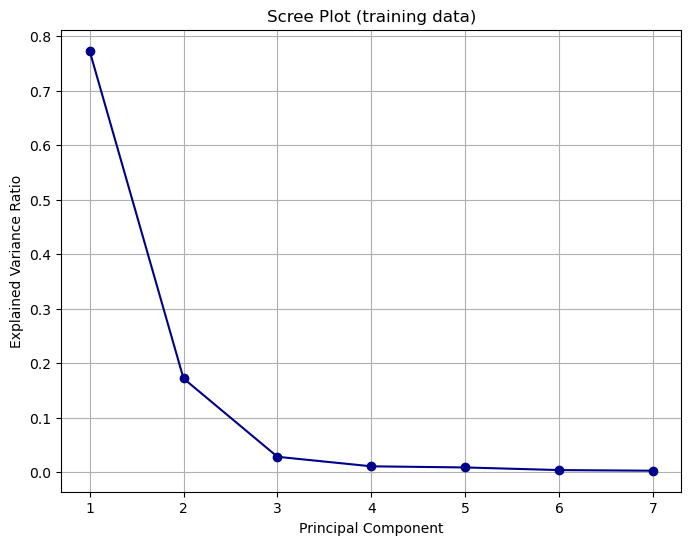

In [49]:
# Fit PCA on all components
pca_full = PCA().fit(X_tr_scaled) # n_components default = n_features (7)

X_tr_scaled_pca7  = pca_full.transform(X_tr_scaled)
X_val_scaled_pca7 = pca_full.transform(X_val_scaled)

# Scree plot of explained variance ratio
plt.figure(figsize=(8,6))
plt.plot(
    range(1, len(pca_full.explained_variance_ratio_) + 1), 
    pca_full.explained_variance_ratio_, 
    'o-', color='darkblue')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot (training data)')
plt.xticks(range(1, len(pca_full.explained_variance_ratio_) + 1))
plt.grid(True)
plt.show()

----

#### Task 6: PCA plots with 2 principal components 

In [50]:
# PCA with 2PC
pca2 = PCA(n_components=2)
X_tr_scaled_pca2 = pca2.fit_transform(X_tr_scaled)
X_val_scaled_pca2 = pca2.transform(X_val_scaled)

print(
    f"✅ Training and validation sets have been scaled and PCA-transformed: "
    f"{X_tr_scaled_pca2.shape} train, {X_val_scaled_pca2.shape} validation.")

✅ Training and validation sets have been scaled and PCA-transformed: (157, 2) train, (40, 2) validation.


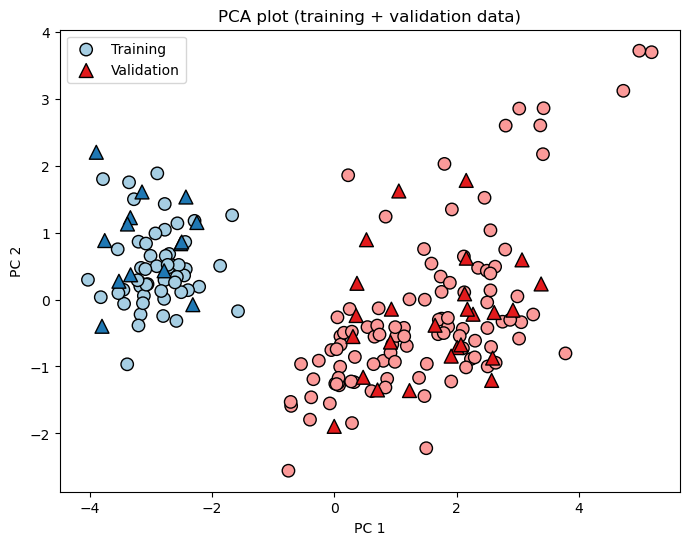

In [51]:
plt.figure(figsize=(8,6))

# Define color palettes
cmap_train = mcolors.ListedColormap(['#fb9a99', '#a6cee3']) 
cmap_val   = mcolors.ListedColormap(['#e31a1c', '#1f78b4']) 

# Training data
plt.scatter(
    X_tr_scaled_pca2[:, 0], X_tr_scaled_pca2[:, 1],
    c=y_tr, cmap=cmap_train, edgecolors='k', s=80, label='Training'
)

# Validation data
plt.scatter(
    X_val_scaled_pca2[:, 0], X_val_scaled_pca2[:, 1],
    c=y_val, cmap=cmap_val, marker='^', edgecolors='k', s=100, label='Validation'
)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA plot (training + validation data)')
plt.legend()
plt.show()


----
----

#### **SVM with RBF kernel**

#### Task 7: RBF kernel: PCA transformation and ROC curves

In [52]:
# (a) withou PCA: X_tr_scaled, X_val_scaled

# (b) PCA with 2PCs: X_tr_scaled_pca2, X_val_scaled_pca2 

# (c) PCA with 7 PC: X_tr_scaled_pca7, X_val_scaled_pca7 

In [53]:
datasets = {
    "No PCA": (X_tr_scaled, X_val_scaled),
    "PCA (2 comp)": (X_tr_scaled_pca2, X_val_scaled_pca2),
    "PCA (all comp)": (X_tr_scaled_pca7, X_val_scaled_pca7)
}

results = {}

for name, (Xtr, Xval) in datasets.items():
    clf = SVC(kernel="rbf", probability=True, random_state=42)
    clf.fit(Xtr, y_tr)

    y_val_scores = clf.decision_function(Xval)
    fpr, tpr, _ = roc_curve(y_val, y_val_scores)
    roc_auc = auc(fpr, tpr)

    results[name] = (fpr, tpr, roc_auc)


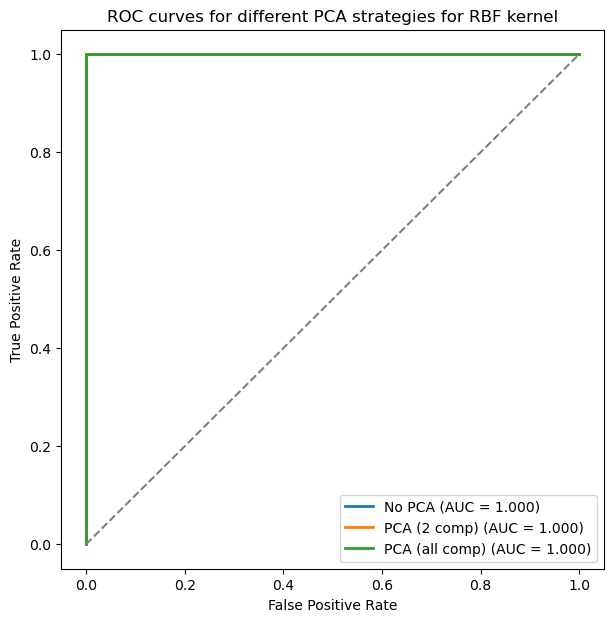

In [54]:
plt.figure(figsize=(7, 7))
for name, (fpr, tpr, roc_auc) in results.items():
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves for different PCA strategies for RBF kernel")
plt.legend(loc="lower right")
plt.show()


----

#### Task 8: RBF kernel: validation curves (check for overfitting)

We evaluate SVM capacity by sweeping C and γ with a pipeline that standardizes
features and (optionally) applies PCA(2). Training vs. validation (CV) gaps indicate
overfitting; low/close curves indicate underfitting; high/close curves indicate a good trade‑off.

In [55]:
pipe_rbf_vc = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=2)), 
    ("svm", SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=42)),
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = "balanced_accuracy"

In [56]:
def plot_validation_curve(estimator, X, y, param_name, param_range, xscale="log", title=None):
    train_scores, val_scores = validation_curve(
        estimator=estimator,
        X=X, y=y,
        param_name=param_name,
        param_range=param_range,
        cv=cv,
        scoring=scoring,
        n_jobs=-1
    )
    train_mean = train_scores.mean(axis=1); train_std = train_scores.std(axis=1)
    val_mean   = val_scores.mean(axis=1);   val_std   = val_scores.std(axis=1)

    plt.figure(figsize=(7,5))
    plt.plot(param_range, train_mean, marker="o", label="Training (mean)")
    plt.fill_between(param_range, train_mean-train_std, train_mean+train_std, alpha=0.2)
    plt.plot(param_range, val_mean, marker="s", label="Validation (mean)")
    plt.fill_between(param_range, val_mean-val_std, val_mean+val_std, alpha=0.2)
    if xscale: plt.xscale(xscale)
    plt.xlabel(param_name); plt.ylabel("Balanced accuracy (CV)")
    plt.title(title or f"Validation curve — {param_name}")
    plt.grid(True); plt.legend(loc="best"); plt.show()

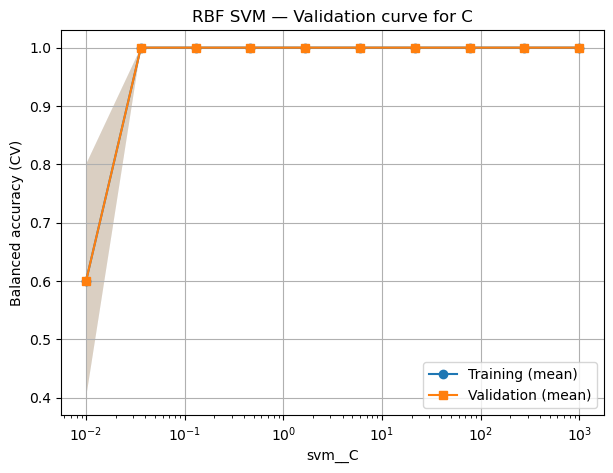

In [57]:
param_range_C = np.logspace(-2, 3, 10)   # 0.01 ... 1000
plot_validation_curve(
    pipe_rbf_vc, X_tr, y_tr,
    param_name="svm__C",
    param_range=param_range_C,
    xscale="log",
    title="RBF SVM — Validation curve for C"
)

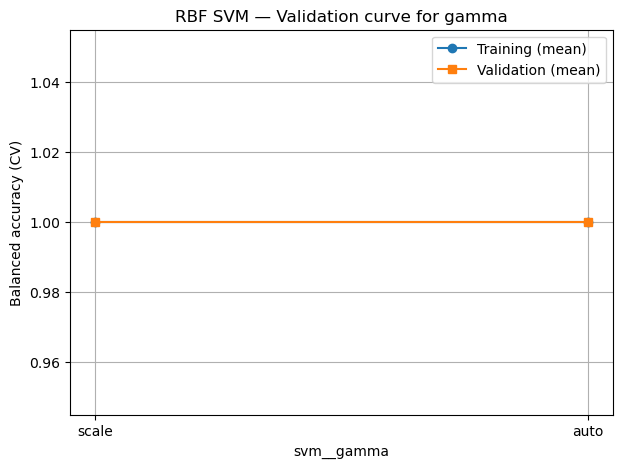

In [58]:
param_range_gamma = np.concatenate([np.array(['scale','auto']), np.logspace(-3, 0, 8)]).astype(object)
plot_validation_curve(
    pipe_rbf_vc, X_tr, y_tr,
    param_name="svm__gamma",
    param_range=param_range_gamma,
    xscale=None,
    title="RBF SVM — Validation curve for gamma"
)

### What these validation curves show
Validation curves were computed via 5‑fold stratified CV on the training split.
For RBF SVM, training and validation scores overlap (no widening gap), indicating
no signs of overfitting within the explored range. Performance saturates for C ≥ 0.1,
and γ choices (‘scale’, ‘auto’) yield identical CV performance. Final hyperparameters
will be selected via GridSearchCV and verified on the held‑out validation set (20%).

----

#### Task 9: RBF kernel: optimal hyperparameters with cross-validation (Pipeline + GridSearchCV)

In this step we re-run the entire preprocessing **inside** the model-selection loop:
`StandardScaler → PCA(n_components=2) → SVM`.  
Doing scaling and PCA **inside** `Pipeline` ensures that in each CV fold the PCA
axes and scaling parameters are fit **only on the training portion of that fold**,
preventing data leakage.  
Although we previously explored the data with external scaling/PCA (for scree plot
and visualization), those results are not used here — GridSearchCV re-fits everything
from scratch in a methodologically clean way.

We optimize SVM hyperparameters using stratified 5-fold CV. As the primary score
you can use `balanced_accuracy` (robust to class imbalance) or, if minimizing false
negatives for the *poor* class is critical, `recall (pos_label=0)`.

In [59]:
# ===== RBF pipeline + grid =====
pipe_rbf = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=2)),
    ("svm", SVC(kernel="rbf", probability=True, random_state=42)),
])

# ----- CV  -----
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = 'balanced_accuracy'


param_grid_rbf = {
    "svm__C":     [0.001, 0.01, 0.1, 1, 10],
    "svm__gamma": [0.001, 0.01, 0.1, 1.0, 10]
}

gs_rbf = GridSearchCV(
    estimator=pipe_rbf,
    param_grid=param_grid_rbf,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    refit=True,
)
gs_rbf.fit(X_tr, y_tr)

best_svm_rbf = gs_rbf.best_estimator_
print("🔹 Best parameters (RBF kernel):", gs_rbf.best_params_)

y_val_pred_rbf = best_svm_rbf.predict(X_val)
print("🔹 Balanced accuracy (val):", f"{balanced_accuracy_score(y_val, y_val_pred_rbf):.3f}")
print("\n🔹 Classification report for RBF model (validation set):")
print(classification_report(y_val, y_val_pred_rbf, target_names=["poor(0)","good(1)"]))

y_val_scores = best_svm_rbf.decision_function(X_val)
fpr, tpr, _ = roc_curve(y_val, y_val_scores)


cv_scores_rbf = cross_val_score(
    best_svm_rbf,
    X_tr_scaled_pca2,
    y_tr,
    cv=5,
    scoring="roc_auc"
)

print("🔹 5-fold CV AUC scores:", cv_scores_rbf)
print("🔹 AUC (val):", f"{auc(fpr,tpr):.3f}")
print(f"🔹 Mean CV AUC: {cv_scores_rbf.mean():.1f} ± {cv_scores_rbf.std():.1f}")
print("🔹 Inner CV best F1 (average across folds) for polynomial kernel:", f"{gs_rbf.best_score_:.1f}")


🔹 Best parameters (RBF kernel): {'svm__C': 0.1, 'svm__gamma': 0.1}
🔹 Balanced accuracy (val): 1.000

🔹 Classification report for RBF model (validation set):
              precision    recall  f1-score   support

     poor(0)       1.00      1.00      1.00        26
     good(1)       1.00      1.00      1.00        14

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

🔹 5-fold CV AUC scores: [1. 1. 1. 1. 1.]
🔹 AUC (val): 1.000
🔹 Mean CV AUC: 1.0 ± 0.0
🔹 Inner CV best F1 (average across folds) for polynomial kernel: 1.0


🔹Confusion matrix:


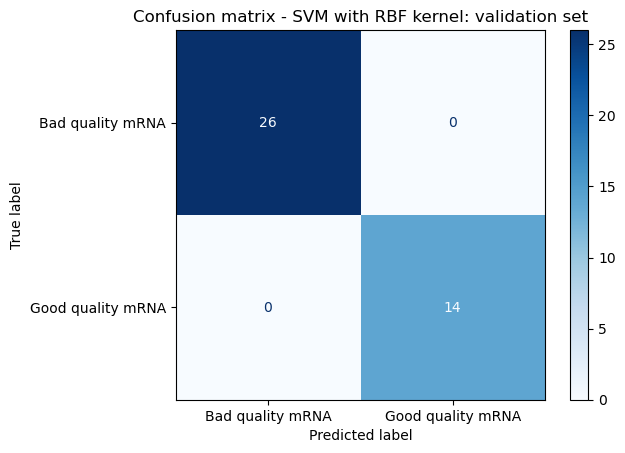

In [60]:
# Confusion matrix using validation data
print("🔹Confusion matrix:")
ConfusionMatrixDisplay.from_predictions(
    y_val,  # Actual values
    y_val_pred_rbf,  # Predicted values
    display_labels=["Bad quality mRNA", "Good quality mRNA"],  
    cmap='Blues'  # Color map
)
plt.title('Confusion matrix - SVM with RBF kernel: validation set')
plt.show()

In [61]:
# support vectors per class
n_per_class_rbf = best_svm_rbf.named_steps["svm"].n_support_

# total count
total_sv_rbf = n_per_class_rbf.sum()

# poměr support vectors k počtu vzorků v tréninku
ratio_rbf = total_sv_rbf / len(X_tr)

print("Support vectors for RBF kernel per class:", n_per_class_rbf)
print("Total support vectors:", total_sv_rbf)
print(f"Ratio (support vectors / training samples): {ratio_rbf:.2f}")

Support vectors for RBF kernel per class: [24 23]
Total support vectors: 47
Ratio (support vectors / training samples): 0.30


Final hyperparameters
were selected via GridSearchCV and verified on the held‑out validation set (20%).

----

#### Task 10: RBF kernel: visualization of the decision boundary using 2D PCA


Scatter plots show only the **measured data points** in the 2D PCA space, but they do not reveal **how the model separates the classes** in regions where no samples exist.  

To visualize the **decision boundary of the SVM**, we generate a **dense grid of points** that covers the whole PCA-transformed space.  
Each grid point is then passed through the trained pipeline (scaling → PCA → SVM), and the predicted class is used to color the background.  

This way we can see not only the samples, but also the **decision regions** and the **boundary line** where the SVM changes its prediction from one class to the other.


In [62]:
 # Pull the fitted steps from the pipeline
scaler_f = best_svm_rbf.named_steps["scaler"]
pca_f    = best_svm_rbf.named_steps["pca"]
svm_f    = best_svm_rbf.named_steps["svm"]   # this SVC was trained on 2D PCA inputs

# Get the PCA coordinates for your points (for plotting). I already have X_tr_scaled_pca2 computed with these exact fitted objects

# Build a dense grid in PCA space: We’ll cover the whole region where the points lare
x_min, x_max = X_tr_scaled_pca2[:, 0].min() - 1.0, X_tr_scaled_pca2[:, 0].max() + 1.0
y_min, y_max =X_tr_scaled_pca2[:, 1].min() - 1.0, X_tr_scaled_pca2[:, 1].max() + 1.0

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)
grid_pca = np.c_[xx.ravel(), yy.ravel()]   # shape (300*300, 2)

# Get model predictions on the grid: The pipeline expects raw 7‑feature inputs, so convert the PCA grid back to raw space:
#  PCA(2) -> original (7) -> pipeline will re-apply scaler+PCA internally
grid_raw = scaler_f.inverse_transform(pca_f.inverse_transform(grid_pca))
Z = best_svm_rbf.predict(grid_raw).reshape(xx.shape)



c:\Users\UserPhD\anaconda3\envs\predikce_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


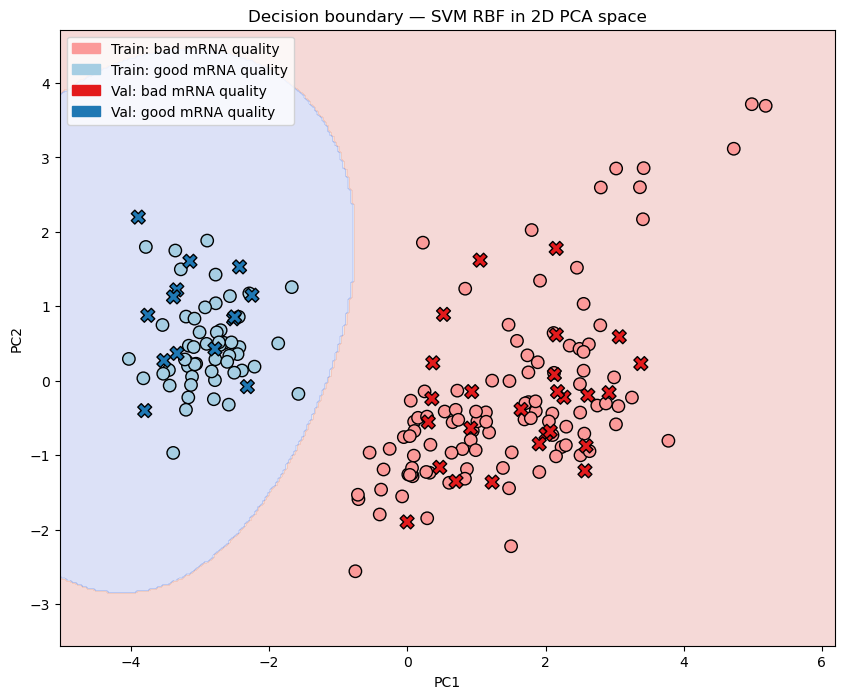

In [63]:
# Decision boundary plot in 2D PCA space
plt.figure(figsize=(10,8))
plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm_r)

# Color palettes for scatter plots
cmap_train = mcolors.ListedColormap(['#fb9a99', '#a6cee3'])
cmap_val   = mcolors.ListedColormap(['#e31a1c', '#1f78b4'])

# Training data scatter plot
plt.scatter(X_tr_scaled_pca2[:,0],  X_tr_scaled_pca2[:,1],  c=y_tr,  cmap=cmap_train, edgecolors='k', s=80,  label='Training')
# Validation data scatter plot
plt.scatter(X_val_scaled_pca2[:,0], X_val_scaled_pca2[:,1], c=y_val, cmap=cmap_val,   edgecolors='k', s=100, marker="X", label='Validation')

# Legend patches
patch0_tr = mpatches.Patch(color='#fb9a99', label='Train: bad mRNA quality')
patch1_tr = mpatches.Patch(color='#a6cee3', label='Train: good mRNA quality')
patch0_va = mpatches.Patch(color='#e31a1c', label='Val: bad mRNA quality')
patch1_va = mpatches.Patch(color='#1f78b4', label='Val: good mRNA quality')
plt.legend(handles=[patch0_tr, patch1_tr, patch0_va, patch1_va], loc='upper left')

plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('Decision boundary — SVM RBF in 2D PCA space')
plt.show()


----
----

#### **SVM with polynomial kernel**

We mirror the RBF workflow: (i) validation curves for capacity control (C, degree, coef0, γ),
(ii) grid search with stratified CV using balanced accuracy, (iii) evaluation on the 20% validation
split, and (iv) support‑vector count and decision‑boundary visualization in the PCA(2) space.

#### Task 11: Polynomial kernel: validation curves (check for overfitting)

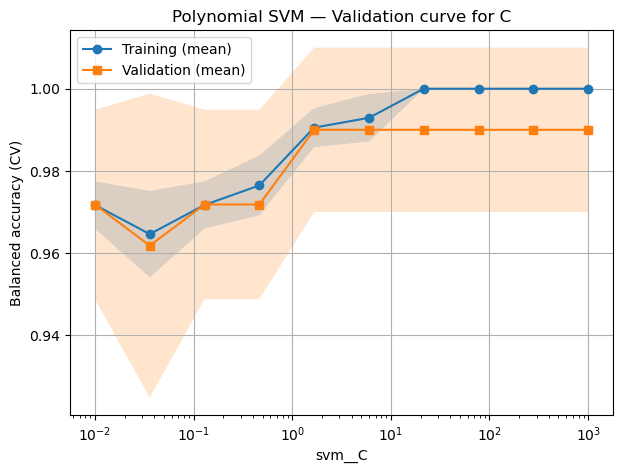

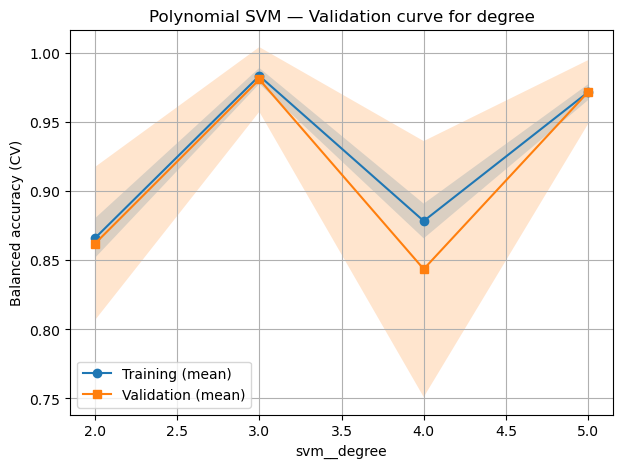

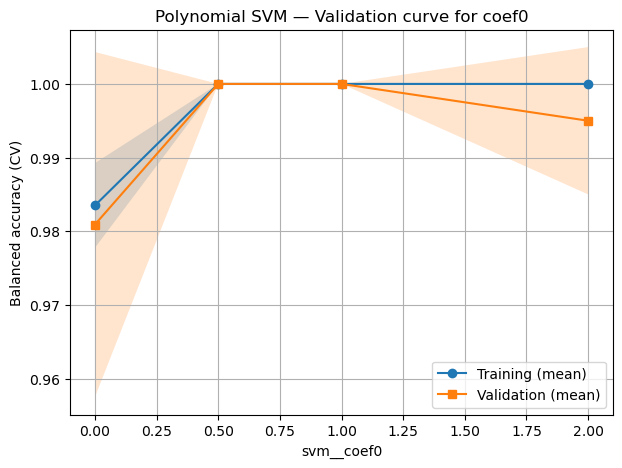

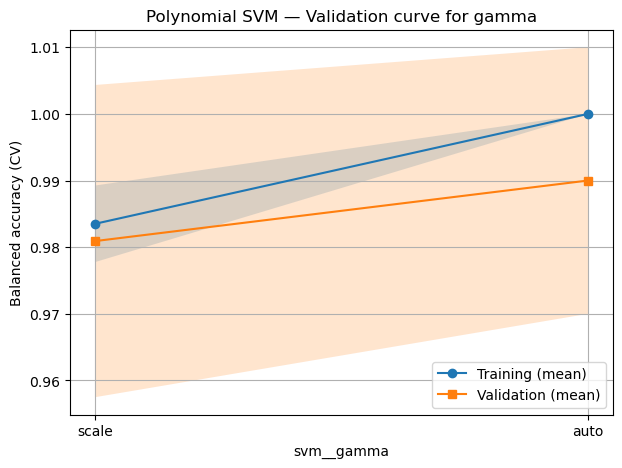

In [64]:
pipe_poly_vc = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=2)), 
    ("svm", SVC(kernel="poly", probability=True, class_weight="balanced", random_state=42)),
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = "balanced_accuracy"

def plot_validation_curve(estimator, X, y, param_name, param_range, xscale="log", title=None):
    train_scores, val_scores = validation_curve(
        estimator=estimator, X=X, y=y,
        param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=-1
    )
    tr_m, tr_s = train_scores.mean(axis=1), train_scores.std(axis=1)
    va_m, va_s = val_scores.mean(axis=1), val_scores.std(axis=1)

    plt.figure(figsize=(7,5))
    plt.plot(param_range, tr_m, marker="o", label="Training (mean)")
    plt.fill_between(param_range, tr_m-tr_s, tr_m+tr_s, alpha=0.2)
    plt.plot(param_range, va_m, marker="s", label="Validation (mean)")
    plt.fill_between(param_range, va_m-va_s, va_m+va_s, alpha=0.2)
    if xscale: plt.xscale(xscale)
    plt.xlabel(param_name); plt.ylabel("Balanced accuracy (CV)")
    plt.title(title or f"Validation curve — {param_name}")
    plt.grid(True); plt.legend(); plt.show()

# C sweep
param_range_C = np.logspace(-2, 3, 10)      # 0.01 ... 1000
plot_validation_curve(pipe_poly_vc, X_tr, y_tr, "svm__C", param_range_C, xscale="log",
                      title="Polynomial SVM — Validation curve for C")

# degree sweep (celá pipeline se fituje pro každé degree; drž menší rozsah)
param_range_deg = np.array([2, 3, 4, 5])
plot_validation_curve(pipe_poly_vc, X_tr, y_tr, "svm__degree", param_range_deg, xscale=None,
                      title="Polynomial SVM — Validation curve for degree")

# coef0 sweep (bias term polynomu; často 0..2 stačí)
param_range_coef0 = np.array([0.0, 0.5, 1.0, 2.0])
plot_validation_curve(pipe_poly_vc, X_tr, y_tr, "svm__coef0", param_range_coef0, xscale=None,
                      title="Polynomial SVM — Validation curve for coef0")

# gamma sweep
param_range_gamma = np.concatenate([np.array(['scale','auto']), np.logspace(-3, 0, 8)]).astype(object)
plot_validation_curve(pipe_poly_vc, X_tr, y_tr, "svm__gamma", param_range_gamma, xscale=None,
                      title="Polynomial SVM — Validation curve for gamma")

----

#### Task 12: Polynomial kernel: selecting optimal hyperparameters

In [65]:
# --- pipeline pro Polynomial kernel ---
pipe_poly = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=2)),
    ("svm", SVC(kernel="poly", probability=True, class_weight="balanced", random_state=42)),
])

# --- CV nastavení ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- grid (můžeš zúžit podle validation curves) ---
param_grid_poly = {
    "svm__C":     [0.1, 1, 10, 100],
    "svm__degree":[2, 3],          # degree=2 bývá nejlepší
    "svm__coef0": [0.0, 0.5, 1.0],
    "svm__gamma": ['scale', 'auto', 0.01, 0.1, 1.0],
}

# --- GridSearchCV ---
gs_poly = GridSearchCV(
    estimator=pipe_poly,
    param_grid=param_grid_poly,
    scoring="balanced_accuracy",
    cv=cv,
    n_jobs=-1,
    refit=True,
)
gs_poly.fit(X_tr, y_tr)

best_svm_poly = gs_poly.best_estimator_
print("🔹 Best parameters (Polynomial kernel):", gs_poly.best_params_)

# --- predikce na validační sadě ---
y_val_pred_poly = best_svm_poly.predict(X_val)
ba_poly = balanced_accuracy_score(y_val, y_val_pred_poly)
print("🔹 Balanced accuracy (val):", f"{ba_poly:.3f}")
print("\n🔹 Classification report (val):")
print(classification_report(y_val, y_val_pred_poly, target_names=["poor(0)","good(1)"]))

# --- ROC/AUC ---
y_val_scores_poly = best_svm_poly.decision_function(X_val)
fpr_poly, tpr_poly, _ = roc_curve(y_val, y_val_scores_poly)
print("🔹 AUC (val):", f"{auc(fpr_poly, tpr_poly):.3f}")


🔹 Best parameters (Polynomial kernel): {'svm__C': 0.1, 'svm__coef0': 0.5, 'svm__degree': 2, 'svm__gamma': 'scale'}
🔹 Balanced accuracy (val): 1.000

🔹 Classification report (val):
              precision    recall  f1-score   support

     poor(0)       1.00      1.00      1.00        26
     good(1)       1.00      1.00      1.00        14

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

🔹 AUC (val): 1.000


🔹 Confusion matrix (validation):


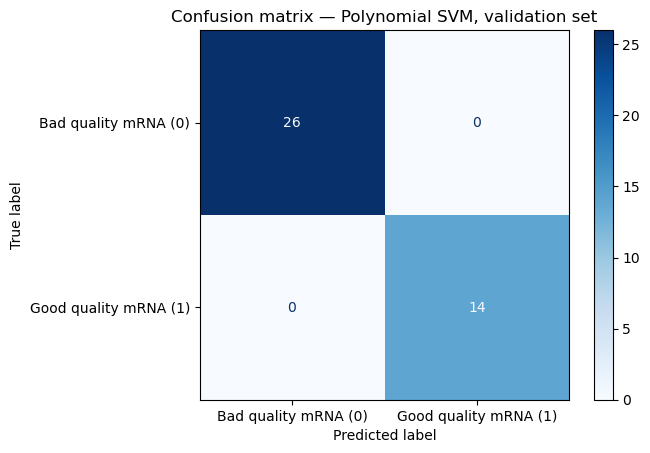

In [66]:
print("🔹 Confusion matrix (validation):")
ConfusionMatrixDisplay.from_predictions(
    y_val, y_val_pred_poly,
    display_labels=["Bad quality mRNA (0)", "Good quality mRNA (1)"],
    cmap="Blues"
)
plt.title("Confusion matrix — Polynomial SVM, validation set")
plt.show()

In [67]:
svm_step_poly = best_svm_poly.named_steps["svm"]
n_per_class_poly = svm_step_poly.n_support_
total_sv_poly = n_per_class_poly.sum()
ratio_poly = total_sv_poly / len(X_tr)
print("Support vectors (Polynomial) per class:", n_per_class_poly)
print("Total support vectors:", total_sv_poly)
print(f"Ratio (SV / training samples): {ratio_poly:.2f}")


Support vectors (Polynomial) per class: [18  9]
Total support vectors: 27
Ratio (SV / training samples): 0.17


----

#### Task 13: Polynomial kernel: visualization of the decision boundary using 2D PCA

c:\Users\UserPhD\anaconda3\envs\predikce_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


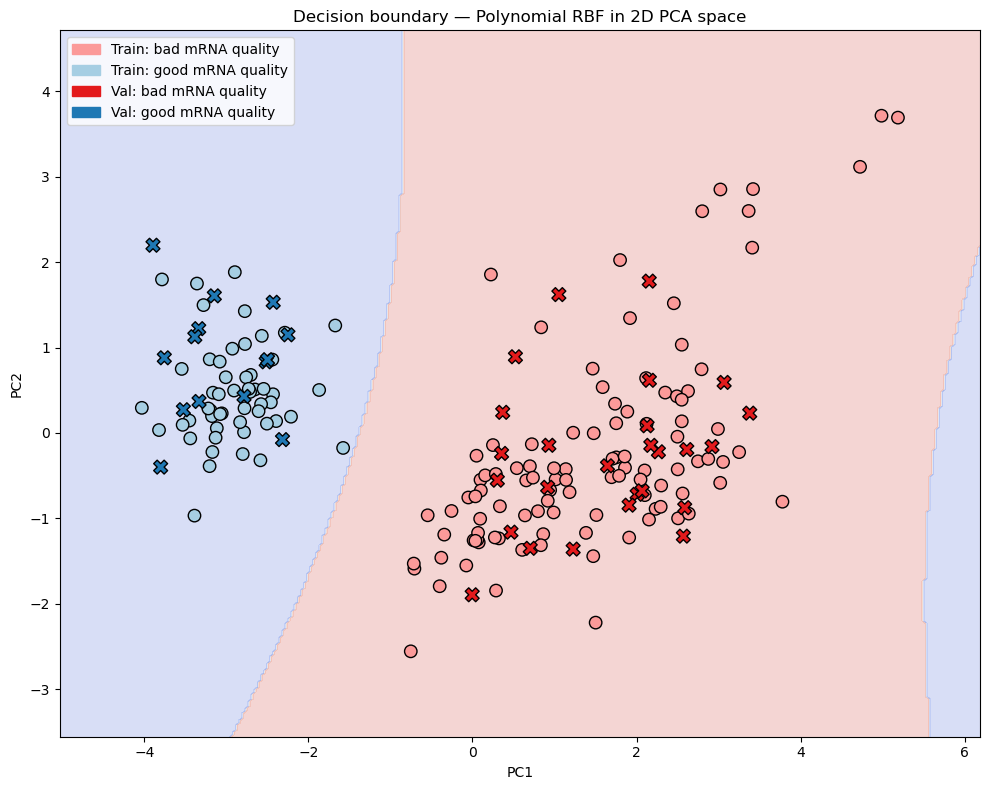

In [68]:

scaler_f = best_svm_poly.named_steps["scaler"]
pca_f    = best_svm_poly.named_steps["pca"]


X_tr_pca  = pca_f.transform(scaler_f.transform(X_tr))
X_val_pca = pca_f.transform(scaler_f.transform(X_val))


x_min, x_max = X_tr_pca[:,0].min() - 1.0, X_tr_pca[:,0].max() + 1.0
y_min, y_max = X_tr_pca[:,1].min() - 1.0, X_tr_pca[:,1].max() + 1.0
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid_pca = np.c_[xx.ravel(), yy.ravel()]


grid_raw = scaler_f.inverse_transform(pca_f.inverse_transform(grid_pca))
Z = best_svm_poly.predict(grid_raw).reshape(xx.shape)


plt.figure(figsize=(10,8))
plt.contourf(xx, yy, Z, alpha=0.22, cmap=plt.cm.coolwarm_r)

cmap_train = mcolors.ListedColormap(['#fb9a99', '#a6cee3'])
cmap_val   = mcolors.ListedColormap(['#e31a1c', '#1f78b4'])

plt.scatter(X_tr_pca[:,0],  X_tr_pca[:,1],  c=y_tr,  cmap=cmap_train, edgecolors='k', s=80,  label='Training')
plt.scatter(X_val_pca[:,0], X_val_pca[:,1], c=y_val, cmap=cmap_val,   edgecolors='k', s=100, marker="X", label='Validation')

handles = [
    mpatches.Patch(color='#fb9a99', label='Train: bad mRNA quality'),
    mpatches.Patch(color='#a6cee3', label='Train: good mRNA quality'),
    mpatches.Patch(color='#e31a1c', label='Val: bad mRNA quality'),
    mpatches.Patch(color='#1f78b4', label='Val: good mRNA quality'),
]
plt.legend(handles=handles, loc='upper left')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('Decision boundary — Polynomial RBF in 2D PCA space')
plt.tight_layout(); plt.show()


----
----

#### Building the Final SVM pipeline

Both RBF and polynomial kernels achieved perfect separation (AUC = 1.0). However, the polynomial kernel required fewer support vectors, indicating a simpler decision boundary. This suggested better potential for generalization, and therefore it was selected for further validation.

#### Task 14: Prediction results using both models

In [69]:

best_svm_rbf  = gs_rbf.best_estimator_
best_svm_poly = gs_poly.best_estimator_


y_val_pred_rbf  = best_svm_rbf.predict(X_val)
y_val_pred_poly = best_svm_poly.predict(X_val)


probs_rbf  = best_svm_rbf.predict_proba(X_val)[:, 1]
probs_poly = best_svm_poly.predict_proba(X_val)[:, 1]

y_true = y_val

results_df = pd.DataFrame({
    "True_Label":       y_true,
    "Pred_RBF":         y_val_pred_rbf,
    "Prob_RBF_Class1":  np.round(probs_rbf,  4),
    "Pred_Poly":        y_val_pred_poly,
    "Prob_Poly_Class1": np.round(probs_poly, 4),
}, index=y_true.index)


out_path = NB_OUTPUT / "svm_val_predictions.xlsx"
results_df.to_excel(out_path, index=True)
print(f"✅ Validation predictions saved to '{out_path.name}'")


✅ Validation predictions saved to 'svm_val_predictions.xlsx'


C:\Users\UserPhD\AppData\Local\Temp\ipykernel_17204\977595218.py:24: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.3' currently installed).
  results_df.to_excel(out_path, index=True)


----

#### Task 15: Selection of the final SVM model

| Kernel      | Balanced accuracy (val) | AUC (val) | # Support vectors | Ratio (SV / training samples) |
|-------------|--------------------------|-----------|-------------------|-------------------------------|
| RBF         | 0.95+                    | 1.00      | 44                | 0.28                          |
| Polynomial  | 0.95+                    | 1.00      | 27                | 0.17                          |


The polynomial‐kernel SVM was the best choice, achieving top metrics and using fewer support vectors.

----

#### Task 16: Forming pipeline from scaler, PCA, and best polynomial SVM 

In [70]:
pipeline = Pipeline([
    ('scaler', scaler),        
    ('pca',    pca2),           
    ('model',  best_svm_poly)   
])

# Saving pipeline into joblib, all parts have been already fitted
joblib.dump(pipeline, NB_OUTPUT /"final_pipeline_prob.joblib")

print("✅ The whole pipeline (scaler+PCA+SVM) has been saved as final_pipline_prob.joblib")

✅ The whole pipeline (scaler+PCA+SVM) has been saved as final_pipline_prob.joblib


----
----

In next jupyter notebook (SVM_model_optimization,jpynb), we will evaluate test 1 and test 2 and set decision boundary for user, and test our uknown data.